# Word Embeddings Experimentation (incomplete)

In [16]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import scipy.sparse
import pronouncing

# modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, Dropout, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint


# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# uncomment to load
with gzip.open('data/poetry_umbrella_genres_df_edit.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
df.columns

Index(['poet_url', 'poem_url', 'poet', 'title', 'poem_lines', 'poem_string',
       'genre', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned'],
      dtype='object')

In [4]:
df.genre.value_counts(normalize=True)

modern          0.292276
metropolitan    0.249543
pre_1900        0.237888
avant_garde     0.220293
Name: genre, dtype: float64

In [5]:
# assign a features dataframe
X = df[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'end_rhyme', 'avg_syllables_word', 'string_titled', 'string_cleaned']]
# assign a target variable
y = df['genre']

In [6]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3282, 9) (3282,)
(1094, 9) (1094,)


In [94]:
# define vocab
vocab = Counter()
# add all docs to vocab
for poem in X_train.string_cleaned:
    words = poem.split()
    vocab.update(word for word in words)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))

28355
[('love', 2218), ('say', 1819), ('day', 1699), ('make', 1656), ('see', 1648), ('eye', 1539), ('know', 1460), ('night', 1434), ('life', 1424), ('man', 1379), ('time', 1333), ('light', 1314), ('old', 1284), ('heart', 1233), ('thing', 1118), ('hand', 1084), ('look', 1072), ('long', 1040), ('still', 1012), ('world', 976), ('take', 973), ('never', 958), ('white', 956), ('sea', 935), ('face', 930), ('let', 917), ('wind', 895), ('sun', 874), ('little', 854), ('even', 846), ('god', 839), ('back', 833), ('men', 827), ('give', 823), ('dream', 823), ('year', 821), ('way', 809), ('thought', 805), ('tree', 793), ('death', 793), ('soul', 785), ('well', 782), ('turn', 767), ('earth', 762), ('away', 758), ('water', 748), ('die', 748), ('head', 743), ('dead', 732), ('air', 730)]


In [95]:
# keep tokens with a min occurrence
min_occurence = 2
tokens = [k for k,c in vocab.items() if c >= min_occurence]
print(len(tokens))

15397


In [96]:
# # uncomment to save
# with gzip.open('data/tokens.pkl', 'wb') as goodbye:
#     pickle.dump(tokens, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/tokens.pkl', 'rb') as hello:
#     tokens = pickle.load(hello)

In [97]:
def clean_string_cleaner(text, vocab):
    words = text.split()
    words = [word for word in words if word in vocab]
    clean_text = ' '.join(words)
    return clean_text

In [98]:
X_train['vocab_string'] = X_train.string_cleaned.apply(lambda x: clean_string_cleaner(x, tokens))
X_test['vocab_string'] = X_test.string_cleaned.apply(lambda x: clean_string_cleaner(x, tokens))

In [99]:

train_docs = X_train.vocab_string
test_docs = X_test.vocab_string

# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)

In [100]:
# sequence encode
encoded_train_docs = tokenizer.texts_to_sequences(train_docs)

In [101]:


# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_train_docs, maxlen=max_length, padding='post')

In [102]:
# sequence encode
encoded_test_docs = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')

In [103]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

In [80]:


# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
# # CUSTOM ADD
model.add(Dropout(0.2))
# # CUSTOM KERNEL
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
# # CUSTOM ADD
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 3861, 50)          724800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 3861, 50)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3859, 32)          4832      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1929, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 61728)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                617290    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
__________

In [104]:
# instantiate the encoder
le = LabelEncoder()

# fit and transform the target train set
ytrain = le.fit_transform(y_train)

# transfomr the target test set
ytest = le.transform(y_test)

In [83]:
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 10
history = model.fit(Xtrain, ytrain, epochs=num_epochs, validation_data=(Xtest, ytest),
                    verbose=2)

Train on 2931 samples, validate on 1445 samples
Epoch 1/10
 - 11s - loss: 1.3812 - acc: 0.2989 - val_loss: 1.3704 - val_acc: 0.3426
Epoch 2/10
 - 11s - loss: 1.3515 - acc: 0.3323 - val_loss: 1.3493 - val_acc: 0.3536
Epoch 3/10
 - 11s - loss: 1.2842 - acc: 0.3896 - val_loss: 1.3347 - val_acc: 0.3578
Epoch 4/10
 - 11s - loss: 1.1951 - acc: 0.4313 - val_loss: 1.3650 - val_acc: 0.3419
Epoch 5/10
 - 11s - loss: 1.1408 - acc: 0.4446 - val_loss: 1.4127 - val_acc: 0.3654
Epoch 6/10
 - 11s - loss: 1.1082 - acc: 0.4565 - val_loss: 1.4824 - val_acc: 0.3529
Epoch 7/10
 - 11s - loss: 1.0643 - acc: 0.4691 - val_loss: 1.5949 - val_acc: 0.3661
Epoch 8/10
 - 11s - loss: 1.0575 - acc: 0.4763 - val_loss: 1.5809 - val_acc: 0.3543
Epoch 9/10
 - 12s - loss: 1.0457 - acc: 0.4916 - val_loss: 1.7831 - val_acc: 0.3626
Epoch 10/10
 - 13s - loss: 1.0261 - acc: 0.5145 - val_loss: 1.7985 - val_acc: 0.3737


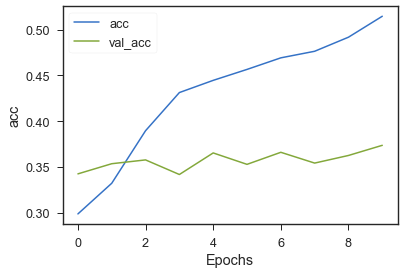

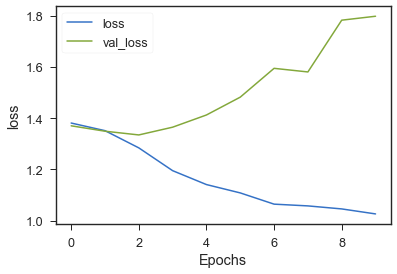

In [84]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [ ]:
max_features = 1000
maxlen = 201
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

In [109]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
# # CUSTOM ADD
model.add(Dropout(0.25))
# # CUSTOM KERNEL
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
# # CUSTOM ADD
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 3868, 100)         1539800   
_________________________________________________________________
dropout_9 (Dropout)          (None, 3868, 100)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3864, 128)         64128     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1932, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 247296)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2472970   
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
__________

In [112]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='data/best_model.h5', monitor='val_loss', save_best_only=True)]

In [114]:
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 10
history = model.fit(Xtrain, ytrain, epochs=num_epochs, validation_data=(Xtest, ytest), callbacks=callbacks,
                    verbose=2)

Train on 3282 samples, validate on 1094 samples
Epoch 1/10
 - 65s - loss: 1.4000 - acc: 0.3221 - val_loss: 1.3504 - val_acc: 0.3803
Epoch 2/10
 - 84s - loss: 1.2755 - acc: 0.3818 - val_loss: 1.2180 - val_acc: 0.4570
Epoch 3/10
 - 82s - loss: 1.0894 - acc: 0.4805 - val_loss: 1.1563 - val_acc: 0.4799
Epoch 4/10
 - 84s - loss: 0.9192 - acc: 0.5551 - val_loss: 1.1758 - val_acc: 0.5101
Epoch 5/10
 - 86s - loss: 0.7930 - acc: 0.5945 - val_loss: 1.2566 - val_acc: 0.4835


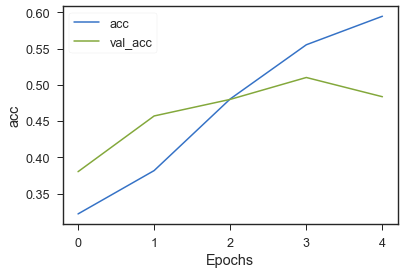

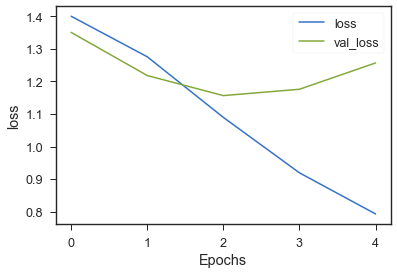

In [115]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [83]:
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 10
history = model.fit(Xtrain, ytrain, epochs=num_epochs, validation_data=(Xtest, ytest),
                    verbose=2)

Train on 2931 samples, validate on 1445 samples
Epoch 1/10
 - 11s - loss: 1.3812 - acc: 0.2989 - val_loss: 1.3704 - val_acc: 0.3426
Epoch 2/10
 - 11s - loss: 1.3515 - acc: 0.3323 - val_loss: 1.3493 - val_acc: 0.3536
Epoch 3/10
 - 11s - loss: 1.2842 - acc: 0.3896 - val_loss: 1.3347 - val_acc: 0.3578
Epoch 4/10
 - 11s - loss: 1.1951 - acc: 0.4313 - val_loss: 1.3650 - val_acc: 0.3419
Epoch 5/10
 - 11s - loss: 1.1408 - acc: 0.4446 - val_loss: 1.4127 - val_acc: 0.3654
Epoch 6/10
 - 11s - loss: 1.1082 - acc: 0.4565 - val_loss: 1.4824 - val_acc: 0.3529
Epoch 7/10
 - 11s - loss: 1.0643 - acc: 0.4691 - val_loss: 1.5949 - val_acc: 0.3661
Epoch 8/10
 - 11s - loss: 1.0575 - acc: 0.4763 - val_loss: 1.5809 - val_acc: 0.3543
Epoch 9/10
 - 12s - loss: 1.0457 - acc: 0.4916 - val_loss: 1.7831 - val_acc: 0.3626
Epoch 10/10
 - 13s - loss: 1.0261 - acc: 0.5145 - val_loss: 1.7985 - val_acc: 0.3737


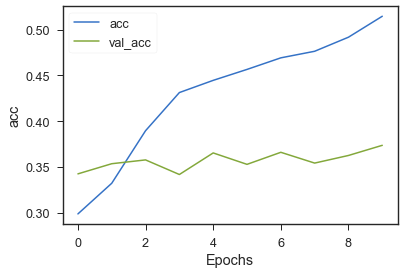

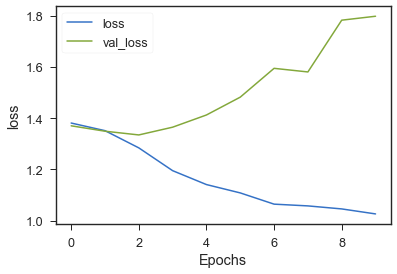

In [84]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [ ]:
max_features = 1000
maxlen = 201
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

In [116]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 150, input_length=max_length))
# # CUSTOM ADD
model.add(Dropout(0.25))
# # CUSTOM KERNEL
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(10, activation='relu', kernel_regularizer='l1'))
# # CUSTOM ADD
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 3868, 150)         2309700   
_________________________________________________________________
dropout_11 (Dropout)         (None, 3868, 150)         0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 3864, 128)         96128     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 966, 128)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 123648)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1236490   
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
__________

In [117]:
# Set callback functions to early stop training and save the best model so far
callbacks2 = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='data/best_model2.h5', monitor='val_loss', save_best_only=True)]

In [118]:
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 10
history = model.fit(Xtrain, ytrain, epochs=num_epochs, validation_data=(Xtest, ytest), callbacks=callbacks2,
                    verbose=2)

Train on 3282 samples, validate on 1094 samples
Epoch 1/10
 - 85s - loss: 5.2685 - acc: 0.2956 - val_loss: 2.9161 - val_acc: 0.3044
Epoch 2/10
 - 101s - loss: 2.9124 - acc: 0.3285 - val_loss: 2.8898 - val_acc: 0.3026
Epoch 3/10
 - 100s - loss: 2.8074 - acc: 0.3860 - val_loss: 2.7690 - val_acc: 0.4223
Epoch 4/10
 - 103s - loss: 2.7172 - acc: 0.4625 - val_loss: 2.7368 - val_acc: 0.4360
Epoch 5/10
 - 104s - loss: 2.5609 - acc: 0.5308 - val_loss: 2.8180 - val_acc: 0.4442
Epoch 6/10
 - 135s - loss: 2.4080 - acc: 0.6402 - val_loss: 2.7764 - val_acc: 0.4616
Epoch 7/10
 - 150s - loss: 2.2885 - acc: 0.7118 - val_loss: 2.9479 - val_acc: 0.4561


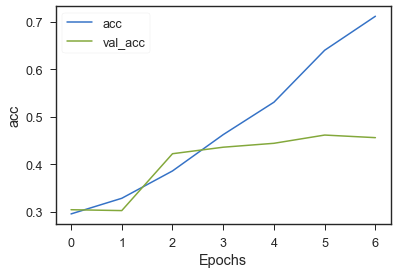

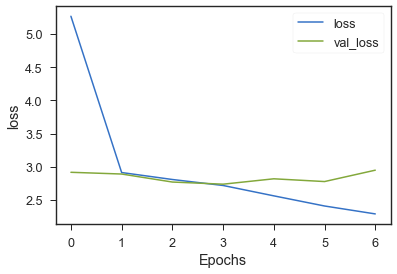

In [119]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

## Pre-trained word embeddings - GloVe
#### The following code borrows heavily from https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/

In [7]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/Users/p.szymo/Documents/word_embeddings/glove6b/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


#### Prepare text data for sequencing

In [11]:
# for this, we'll be using raw poems, so assign those to respective variables
train_docs_raw = X_train.string_titled
test_docs_raw = X_test.string_titled

# create the tokenizer
tokenizer = Tokenizer()

# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs_raw)

# converting text into integer sequences
X_train_seq = tokenizer.texts_to_sequences(train_docs_raw) 
X_test_seq = tokenizer.texts_to_sequences(test_docs_raw)

# compute the length of the longest poem, so we can use that as the maxlen of the sequences
maxlen = max([len(poem.split()) for poem in train_docs_raw])

# padding to prepare sequences of same length
X_train_seq = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_seq = pad_sequences(X_test_seq, maxlen=maxlen)

In [14]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

46438

#### Assign each token to its corresponding pretrained vector

In [15]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### Convert target classes to floats

In [19]:
# instantiate the encoder
le = LabelEncoder()

# fit and transform the target train set
y_train_le = le.fit_transform(y_train)

# transfomr the target test set
y_test_le = le.transform(y_test)

### Build a model - CNN

In [26]:
model_cnn = Sequential()

# embedding layer
model_cnn.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)) 

# dropout layer
model_cnn.add(Dropout(0.2))

# cnn layer
model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# maxpooling
model_cnn.add(MaxPooling1D())

# flatten
model_cnn.add(Flatten())

# dense layer (with another dropout)
model_cnn.add(Dense(10, activation='relu')) 
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(4, activation='softmax'))

# add loss function, metrics, optimizer
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)  
mc = ModelCheckpoint('data/best_model_pretrained.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

# print summary of model
print(model_cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 7408, 300)         13931400  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7408, 300)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7404, 128)         192128    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3702, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 473856)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                4738570   
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
__________

#### Train that model

In [27]:
history = model_cnn.fit(np.array(X_train_seq), np.array(y_train_le), 
                    batch_size=128, epochs=10, 
                    validation_data=(np.array(X_test_seq), np.array(y_test_le)), 
                    verbose=2, callbacks=[es, mc])

Train on 3282 samples, validate on 1094 samples
Epoch 1/10
 - 269s - loss: 1.4164 - acc: 0.2971 - val_loss: 1.3834 - val_acc: 0.3044

Epoch 00001: val_acc improved from -inf to 0.30439, saving model to data/best_model_pretrained.h5
Epoch 2/10
 - 301s - loss: 1.3962 - acc: 0.2934 - val_loss: 1.3781 - val_acc: 0.2971

Epoch 00002: val_acc did not improve from 0.30439
Epoch 3/10
 - 314s - loss: 1.3892 - acc: 0.2940 - val_loss: 1.4109 - val_acc: 0.3007

Epoch 00003: val_acc did not improve from 0.30439
Epoch 4/10
 - 341s - loss: 1.3926 - acc: 0.2965 - val_loss: 1.3749 - val_acc: 0.2980

Epoch 00004: val_acc did not improve from 0.30439
Epoch 5/10
 - 337s - loss: 1.3816 - acc: 0.2928 - val_loss: 1.3822 - val_acc: 0.2925

Epoch 00005: val_acc did not improve from 0.30439
Epoch 6/10
 - 332s - loss: 1.3812 - acc: 0.2928 - val_loss: 1.3818 - val_acc: 0.2925

Epoch 00006: val_acc did not improve from 0.30439
Epoch 7/10
 - 394s - loss: 1.3813 - acc: 0.2925 - val_loss: 1.3815 - val_acc: 0.2925

Ep

In [28]:
X_train_seq

array([[   0,    0,    0, ...,   23, 1846,  121],
       [   0,    0,    0, ...,   25,   37,   64],
       [   0,    0,    0, ...,  305,   36, 1848],
       ...,
       [   0,    0,    0, ..., 4032, 2590, 8742],
       [   0,    0,    0, ...,  995,    2, 1262],
       [   0,    0,    0, ...,  249, 6367,  556]], dtype=int32)

In [29]:
history = model_cnn.fit(np.array(X_train_seq), np.array(y_train_le), 
                        validation_data=(np.array(X_test_seq), np.array(y_test_le)), 
                        epochs=10, verbose=2, callbacks=[es, mc])

Train on 3282 samples, validate on 1094 samples
Epoch 1/10
 - 326s - loss: 1.3806 - acc: 0.2928 - val_loss: 1.3811 - val_acc: 0.2925

Epoch 00001: val_acc did not improve from 0.30439
Epoch 2/10
 - 288s - loss: 1.3802 - acc: 0.2928 - val_loss: 1.3808 - val_acc: 0.2925

Epoch 00002: val_acc did not improve from 0.30439
Epoch 3/10
 - 266s - loss: 1.3802 - acc: 0.2928 - val_loss: 1.3808 - val_acc: 0.2925

Epoch 00003: val_acc did not improve from 0.30439
Epoch 4/10
 - 255s - loss: 1.3801 - acc: 0.2928 - val_loss: 1.3808 - val_acc: 0.2925

Epoch 00004: val_acc did not improve from 0.30439
Epoch 5/10
 - 301s - loss: 1.3801 - acc: 0.2928 - val_loss: 1.3807 - val_acc: 0.2925

Epoch 00005: val_acc did not improve from 0.30439
Epoch 6/10
 - 365s - loss: 1.3801 - acc: 0.2928 - val_loss: 1.3807 - val_acc: 0.2925

Epoch 00006: val_acc did not improve from 0.30439
Epoch 7/10
 - 381s - loss: 1.3804 - acc: 0.2925 - val_loss: 1.3807 - val_acc: 0.2925

Epoch 00007: val_acc did not improve from 0.30439


### Build a model - LSTM

In [24]:
model_lstm = Sequential()

# embedding layer
model_lstm.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)) 

# lstm layer
model_lstm.add(LSTM(128, return_sequences=True, dropout=0.2))

# global maxpooling
model_lstm.add(GlobalMaxPooling1D())

# dense Layer
model_lstm.add(Dense(64,activation='relu')) 
model_lstm.add(Dense(4,activation='softmax'))

# add loss function, metrics, optimizer
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)  
mc = ModelCheckpoint('data/best_model_pretrained.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

# print summary of model
print(model_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 7408, 300)         13931400  
_________________________________________________________________
lstm_4 (LSTM)                (None, 7408, 128)         219648    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260       
Total params: 14,159,564
Trainable params: 228,164
Non-trainable params: 13,931,400
_________________________________________________________________
None


#### Train that model

In [23]:
# history = model_lstm.fit(np.array(X_train_seq), np.array(y_train_le), 
#                     batch_size=128, epochs=10, 
#                     validation_data=(np.array(X_test_seq), np.array(y_test_le)), 
#                     verbose=2, callbacks=[es, mc])